# Supervised learning – an issue with distance measures, and an introduction to linear classification with the Perceptron

## Introduction

In this lab we will expand on some of the concepts of linear
classification, starting with an experiment with distance measures on data, then looking into the perceptron. Initially we understand the representational capacity of a perceptron, then how to implement learning for elementary Boolean functions, i.e., concept learning, and finally look at a perceptron learning a linear classifier on a real-world dataset.

### Acknowledgement

The perceptron implementation for this lab is based on the presentation and code in Chapter 3 of ``Machine Learning'' by Stephen Marsland, CRC Press, 2015.

## Distance measures for high-dimensionality data

Algorithms such as $k$-Nearest Neighbour are conceptually very simple -- we predict the class value of an unlabelled *query* data point we are given by looking at all the labelled data point(s) in our data set, and predicting that our query will have the same class as the most similar data point(s) in the training set. So, all we need is a way of measuring similarity. The well-known *Euclidean distance measure* would seem to be a good choice. However, while we are very familiar with Euclideam distance in 2 and 3-dimensions, there was a warning (Slide 33 of the "Classification" lecture) that in high-dimensions there is a problem – what was this problem ? 

### Pairwise distances in high-dimensional spaces 

Answer: in high-dimensional spaces everything is far away from everything else, and so pairwise distances become uninformative.

But what does this actually mean ? There is a mathematical argument to show that this is a true statement, but an alternative approach is simply to simulate what happens. One approach is to randomly generate $N$ points inside a $d$-dimensional cube centred around zero, such as $[-0.5, 0.5]^{d}$. Now take all $N^2$ pairwise distances between these points and plot them. Try setting $N=50$ and do this for at least 3 settings for $d$, such as $d=3$, $100$ and $1000$. Plot the pairwise distances using a histogram from the [```matplotlib```](http://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) library. What do you observe as $d$ is increased ? Does this support the statement above ?

You should use the ```numpy``` library for this, and in particular the linear algebra methods to calculate the distance as the [L2 norm](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm). 

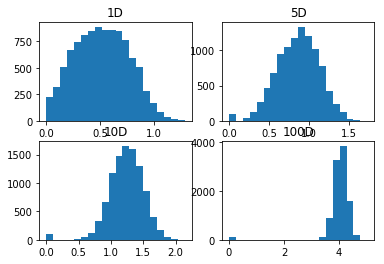

[0.48251620096573045, 0.3094060746184458, 0.21911661870661198, 0.1160507072202198]


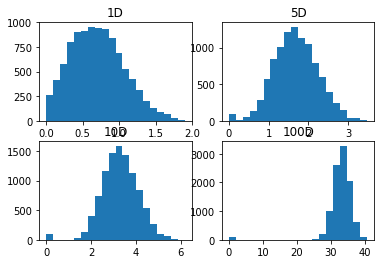

[0.5158728473662265, 0.33026324163635756, 0.24920881596913802, 0.1227993099424837]


In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


def run_d_n(my_dim,my_pts,L):
	my_dts = my_pts * my_pts
	my_a = np.zeros((my_pts,my_dim))
	my_d = np.zeros(my_dts)

	for i in range(0, my_pts):
	    my_a[i] = np.random.rand(1,my_dim)
	    my_a[i] -= 0.5
	    
	for i in range(0, my_pts):
	    for j in range (0, my_pts):
	        my_pair_idx = (i*my_pts)+j
	        # L2 norm (Euclidean distance)
	        dist = np.linalg.norm(my_a[i]-my_a[j],L)
	        # You could also try the L1 norm – does it change anything ?
	        # L1 norm (Manhattan or city-block distance)
	        # dist = np.linalg.norm(my_a[i]-my_a[j], 1)
	        my_d[my_pair_idx] = dist
	return my_d
cv_list=[]
plt.figure(1)
plt.axis('off')
plt.subplot(2,2,1)
plt.title("1D")
my_d=run_d_n(2,100,2)
cv_list.append(np.std(my_d)/np.mean(my_d))
plt.hist(my_d, 20)
plt.subplot(2,2,2)
plt.title("5D")
my_d=run_d_n(5,100,2)
cv_list.append(np.std(my_d)/np.mean(my_d))
plt.hist(my_d, 20)
plt.subplot(2,2,3)
plt.title("10D")
my_d=run_d_n(10,100,2)
cv_list.append(np.std(my_d)/np.mean(my_d))
plt.hist(my_d, 20)
plt.subplot(2,2,4)
plt.title("100D")
my_d=run_d_n(100,100,2)
cv_list.append(np.std(my_d)/np.mean(my_d))
plt.hist(my_d, 20)
plt.show()
print(cv_list)

cv_list=[]
plt.figure(1)
plt.axis('off')
plt.subplot(2,2,1)
plt.title("1D")
my_d=run_d_n(2,100,1)
cv_list.append(np.std(my_d)/np.mean(my_d))
plt.hist(my_d, 20)
plt.subplot(2,2,2)
plt.title("5D")
my_d=run_d_n(5,100,1)
cv_list.append(np.std(my_d)/np.mean(my_d))
plt.hist(my_d, 20)
plt.subplot(2,2,3)
plt.title("10D")
my_d=run_d_n(10,100,1)
cv_list.append(np.std(my_d)/np.mean(my_d))
plt.hist(my_d, 20)
plt.subplot(2,2,4)
plt.title("100D")
my_d=run_d_n(100,100,1)
cv_list.append(np.std(my_d)/np.mean(my_d))
plt.hist(my_d, 20)
plt.show()
print(cv_list)

## Linear classification with the Perceptron

### Getting started

In this lab we will use a slight variant on the notation and setup
used in the lectures.
These changes are not going to affect the capabilities of the perceptron.

For a given set of $m$ inputs, the first stage of the computation is when the perceptron  multiplies each of the input values with its corresponding weight and adds these together:

$$ h = \sum_{i}^{m} w_{i} x_{i} $$

The second stage is to apply the thresholding output rule or activation function of the perceptron to produce the classification output.

For this lab we will slightly change the activation function to map to either $0$ or $1$ rather than the $-1$ or $+1$ we had in the lecture notes.

The value set for the bias or threshold input will also be changed from $1$ to $-1$.

$$ o = g(h) = \left\{
                \begin{array}{lll}
                        1 & \mbox{if}           & h > 0 \\
                        0 & \mbox{otherwise if} & h \leq 0 \\
                \end{array}
              \right. $$

Let's go ahead and implement a Perceptron in Python.

## Representing simple Boolean functions as a linear classifier

We will first look at modelling a simple two-input Boolean function as linear classifier. This is a Perceptron WITHOUT any learning! To get started we will use the OR function, for which the truth table will be familiar to you all. Note that you will need to pick some weights for the function to output the correct values given the input. There are many possible values that could do the job. Also, remember to take care with the dimension of the weight vector.

In [15]:
# set up the data, i.e., all the cases in the truth table 
x=[[0,0],[0,1],[1,0],[1,1]]
y=[0,1,1,1]
# number of data points
n=4
# number of inputs to the perceptron
m=3
# what weights should be assigned to correctly compute the OR function ?
w=[0.02,0.03,0.03]
# loop over the data
for i in range(n):
    h=w[0]*(-1)# this is the bias weight and input
    for j in range(1,m):
        h+=w[j]*x[i][j-1]
    if(h>0):
        output=1
    else:
        output=0
    print ('For Input', x[i], 'with Class', y[i], 'Predict ', output)

For Input [0, 0] with Class 0 Predict  0
For Input [0, 1] with Class 1 Predict  1
For Input [1, 0] with Class 1 Predict  1
For Input [1, 1] with Class 1 Predict  1


Now change your code to model the AND function (again restricted to two inputs).

In [19]:
# set up the data, i.e., all the cases in the truth table 
x=[[0,0],[0,1],[1,0],[1,1]]
y=[0,1,1,1]
# number of data points
n=4
# number of inputs to the perceptron
m=3
# what weights should be assigned to correctly compute the AND function ?
w=[0.05,0.03,0.03]
# loop over the data
for i in range(n):
    h=w[0]*(-1)# this is the bias weight and input
    for j in range(1,m):
        h+=w[j]*x[i][j-1]
    if(h>0):
        output=1
    else:
        output=0
    print ('For Input', x[i], 'with Class', y[i], 'Predict ', output)

For Input [0, 0] with Class 0 Predict  0
For Input [0, 1] with Class 1 Predict  1
For Input [1, 0] with Class 1 Predict  1
For Input [1, 1] with Class 1 Predict  1


## Changing the data structures for machine learning

We got right down to the details of how a linear classifier works. Now this being a perceptron, you probably recall that rather than using a fixed set of weights to do the prediction each time, there is a simple training rule that updates the weights on the basis of discrepancies between the classifier's prediction on the data and the actual class. So we could extend our previous code to implement that training rule, but the code is a little fiddly and you're probably thinking there should be a simpler way to do this. If so, you are correct, but it is based on moving towards coding with matrix and vector operations, rather than directly using Python arrays. To do this we need to import the NumPy library (there is a tutorial at: <href <a>https://docs.scipy.org/doc/numpy-dev/user/quickstart.html</a>>).

For example, when we need to predict a class for an instance $\mathbf{x}$ given the current weights $\mathbf{w}$ we can use the inner product operation $\mathbf{x} \cdot \mathbf{w}$. To get this functionality using NumPy we just do the following:

In [4]:
import numpy as np

x=np.array([0,1,1])
w=np.array([0.02,0.03,0.03])

h=np.dot(x,w)
print (h)

0.06


But wait, there's more! Since $\mathbf{x}$ and $\mathbf{w}$ are both actually matrices, the same operation will enable us to apply the inner product of the weight vector $\mathbf{w}$ to ALL the data instances at once. In this case we write the matrix of data instances $\mathbf{X}$. Just note that we need to take care that the data matrix and weight vector are properly initialised to make this operation work correctly. Now the code for predicting the class values of all of our data given the weight vector is as follows: 

In [28]:
import numpy as np

# Data set with class values in last column
dataset = np.array([[0,0,0],[0,1,1],[1,0,1],[1,1,1]]) # OR function
X=dataset[:,0:2]
y = dataset[:,2:]
# Note: the bias weight is now the last!
w = np.array([[0.03],[0.03],[0.02]])
# Add the values for the bias weights (-1) to the data matrix
nData = np.shape(X)[0]
X = np.concatenate((X,-np.ones((nData,1))),axis=1)
# get the value of the activation function
h = np.dot(X,w)
yhat = np.where(h>0,1,0)
err = yhat-y
for i in range(nData):
	print ("data",X[i],"w",w.reshape(-1))
	print('Activations:', round( h[i][0],2 ),'Predictions:', yhat[i][0],'Misclassifications', err[i][0])
	print ()

data [ 0.  0. -1.] w [0.03 0.03 0.02]
Activations: -0.02 Predictions: 0 Misclassifications 0

data [ 0.  1. -1.] w [0.03 0.03 0.02]
Activations: 0.01 Predictions: 1 Misclassifications 0

data [ 1.  0. -1.] w [0.03 0.03 0.02]
Activations: 0.01 Predictions: 1 Misclassifications 0

data [ 1.  1. -1.] w [0.03 0.03 0.02]
Activations: 0.04 Predictions: 1 Misclassifications 0



This code uses some more NumPy built-ins. Check the documentation to be sure you know what is going on. One of these, np.where(), is useful here. It takes 3 arguments and returns an array. The first argument is a predicate on an array that is either evaluates to true, returning the second argument at the corresponding index in the array or false, returning the third argument instead. Now see how you get on re-implementing the code to do the prediction for the two-input Boolean AND function, as above.

In [29]:
import numpy as np

# Data set with class values in last column
dataset = np.array([[0,0,0],[0,1,0],[1,0,0],[1,1,1]]) # AND function
X=dataset[:,0:2]
y = dataset[:,2:]
# Note: the bias weight is now the last!
w = np.array([[0.03],[0.03],[0.05]])
# Add the values for the bias weights (-1) to the data matrix
nData = np.shape(X)[0]
X = np.concatenate((X,-np.ones((nData,1))),axis=1)
# get the value of the activation function
h = np.dot(X,w)
yhat = np.where(h>0,1,0)
err = yhat-y
for i in range(nData):
	print ("data",X[i],"w",w.reshape(-1))
	print('Activations:', round( h[i][0],2 ),'Predictions:', yhat[i][0],'Misclassifications', err[i][0])
	print ()

data [ 0.  0. -1.] w [0.03 0.03 0.05]
Activations: -0.05 Predictions: 0 Misclassifications 0

data [ 0.  1. -1.] w [0.03 0.03 0.05]
Activations: -0.02 Predictions: 0 Misclassifications 0

data [ 1.  0. -1.] w [0.03 0.03 0.05]
Activations: -0.02 Predictions: 0 Misclassifications 0

data [ 1.  1. -1.] w [0.03 0.03 0.05]
Activations: 0.01 Predictions: 1 Misclassifications 0



## Adding in weight updates to make the learning work

We have spent some time just getting the weights and data in the right vector-matrix format to be able to do the prediction. What else do we need to get this thing to learn ?

One thing we will need is some random initialisation for the weight vector. What sort of values would be appropriate for this initialisation?

The initialisation will be done using a NumPy built-in. Note that we need weights for each of the inputs "nIn", plus one for the bias. Also, the "nOut" parameter is just a placeholder in case you want your Perceptron to predict more than one output at a time. Here we will just use one.

In [31]:
nIn = 2    # still working with 2-input Boolean functions
nOut = 1   # so a true/false classification output
w = np.random.rand(nIn+1,nOut)*0.1-0.05 # Check: does this return a column vector?
print (w)

[[ 0.04669702]
 [-0.00738479]
 [-0.04706778]]


The other main thing we need is to see how the Perceptron training rule is implemented to update the weights for each attribute given all the information in the data matrix plus the misclassifications. Note that this implementation is a batch version, unlike the version in the lecture notes which is incremental. Both approaches have their place. Here we go for simplicity of implementation.

What must the inner dimensions of the matrix multiplcation be for the weight update ? Check with the lecture notes to see what terms we will need. Recall that the augmented data matrix has $m+1$ columns, where $m$ is the number of inputs. However, the misclassifications, or errors, are of dimensionality $n$, because there is potentially one misclassification for every example in the dataset. What has to happen ?

Correct: you need to transpose the augmented data matrix to ensure the inner dimensions match (they both must be of size $n$). Check you are sure before inspecting the code (it's just a one-liner). Here the parameter "eta" is the learning rate $\eta$, which for this code is set to $0.25$. Once more $\hat{y} - y$ will be our misclassification vector. Can you see why the updated weight vector $w$ has the values it does ?

In [8]:
eta=0.25
w -= eta*np.dot(np.transpose(X),yhat-y)   # this is it - learning in one line of code!
print w

[[ 0.03615686]
 [ 0.02827902]
 [ 0.03459717]]


Now we can put all the above together. Note that we need to set an upper limit for the number of iterations (T). Play with this code and run it as above for our Boolean functions. See what happens to the weights for "OR". Does the Perceptron learn this function. Now try "AND". Then try "XOR" (exclusive or). Now go back and experiment with the learning rate. Does anything change ?

In [47]:
from __future__ import division
import numpy as np

# Dataset with class values in last column
#dataset = np.array([[0,0,0],[0,1,1],[1,0,1],[1,1,1]])   # OR function
#dataset = np.array([[0,0,0],[0,1,0],[1,0,0],[1,1,1]]) # AND function
dataset = np.array([[0,0,0],[0,1,1],[1,0,1],[1,1,0]]) # XOR function
X = dataset[:,0:2]
y = dataset[:,2:]
nIn = np.shape(X)[1]    # no. of columns of data matrix
nOut = np.shape(y)[1]   # no. of columns of class values -- just 1 here
nData = np.shape(X)[0]  # no. of rows of data matrix
w = np.random.rand(nIn+1,nOut)*0.1-0.05
X = np.concatenate((X,-np.ones((nData,1))),axis=1)
eta=0.25
T=20
# Train for T iterations
for t in range(T):
        # Predict outputs given current weights
        h = np.dot(X,w)
        yhat = np.where(h>0,1,0)
        # Update weights for all incorrect classifications
        w -= eta*np.dot(np.transpose(X),yhat-y)
        # Output current performance
        errors=yhat-y
        perrors=((nData - np.sum(np.where(errors==0,1,0)))/nData)
        #print perrors, 'is Error on iteration:', t
        print ('Iteration:', t, ' Error:', perrors)

Iteration: 0  Error: 0.75
Iteration: 1  Error: 0.5
Iteration: 2  Error: 0.5
Iteration: 3  Error: 0.5
Iteration: 4  Error: 0.5
Iteration: 5  Error: 0.5
Iteration: 6  Error: 0.5
Iteration: 7  Error: 0.5
Iteration: 8  Error: 0.5
Iteration: 9  Error: 0.5
Iteration: 10  Error: 0.5
Iteration: 11  Error: 0.5
Iteration: 12  Error: 0.5
Iteration: 13  Error: 0.5
Iteration: 14  Error: 0.5
Iteration: 15  Error: 0.5
Iteration: 16  Error: 0.5
Iteration: 17  Error: 0.5
Iteration: 18  Error: 0.5
Iteration: 19  Error: 0.5


## Perceptron training on real data

Finally, try this out on a real dataset, the Pima diabetes dataset. You can download this from within your program. The rest of your program should work the same. Replace the lines defining the dataset, X and y variables with the code below. You might want to increase the number of iterations from 20 as well. Unfortunately, this basic implementation of neural learning is not likely to find a very good model. You could try transforming the data, for example, by making all attribute values lie in the same range. Search for methods of normalisation using the NumPy built-in functions "np.mean()" and "np.var()".

In [10]:
import urllib
# URL for a copy of the Pima Indians Diabetes dataset (UCI Machine Learning Repository)
url = "http://cse.unsw.edu.au/~mike/comp9417/data/uci_pima_indians_diabetes.csv"
# download the file
raw_data = urllib.urlopen(url)
# load the CSV file as a numpy matrix
dataset = np.loadtxt(raw_data, delimiter=",")
print(dataset.shape) # 8 attributes, 1 class, 768 examples
X = dataset[:,0:8]
y = dataset[:,8:9]


(768, 9)


Here is the full code

(768, 9)


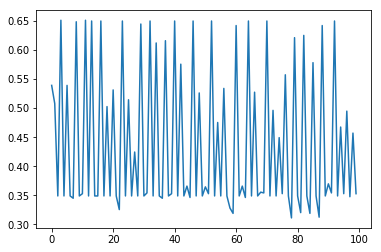

In [45]:
from __future__ import division
import numpy as np

import urllib
# URL for a copy of the Pima Indians Diabetes dataset (UCI Machine Learning Repository)
url = "http://cse.unsw.edu.au/~mike/comp9417/data/uci_pima_indians_diabetes.csv"
# download the file
raw_data = urllib.request.urlopen(url)
# load the CSV file as a numpy matrix
dataset = np.loadtxt(raw_data, delimiter=",")
print(dataset.shape) 
X = dataset[:,0:8]
y = dataset[:,8:9]

nIn = np.shape(X)[1]    # no. of columns of data matrix
nOut = np.shape(y)[1]   # no. of columns of class values -- just 1 here
nData = np.shape(X)[0]  # no. of rows of data matrix
w = np.random.rand(nIn+1,nOut)*0.1-0.05
X = np.concatenate((X,-np.ones((nData,1))),axis=1)
eta=0.0000004
T=100
error_list=[]
# Train for T iterations
for t in range(T):
        # Predict outputs given current weights
        h = np.dot(X,w)
        yhat = np.where(h>0,1,0)
        # Update weights for all incorrect classifications
        w -= eta*np.dot(np.transpose(X),yhat-y)
        # Output current performance
        errors=yhat-y
        perrors=((nData - np.sum(np.where(errors==0,1,0)))/nData)
        #print perrors, 'is Error on iteration:', t
        #print ('Iteration:', t, ' Error:', perrors)
        error_list.append(perrors)
plt.plot(error_list)
plt.show()